# Statistics in Machine Learning: STA 208
# Final Project
## Stroke Prediction/Prevention

URL: https://www.kaggle.com/lirilkumaramal/heart-stroke


### Imports

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
folder_mac = "/Users/Dylan/Desktop/School Stuff/Master's Year/Spring 2021/STA 208/Final Project/"
folder_windows = "C:/Users/Dylan/Documents/Spring 2021/STA 208/Final Project/"
filename = "train_strokes.csv"
df = pd.read_csv(folder_mac+filename, na_values="N/A")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


## Data Preparation

### Dealing with Null values

In [5]:
df.isna().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [6]:
# Only the bmi variable has NA values. I think the best course of action is to replace
# BMI nas with the median value of the patient's gender
# Ex. If patitent is female, replace their BMI with the median value for females
# We also want to drop the na values so that we can come up with a median value
male_df = df.loc[df['gender'] == "Male"].dropna()
male_bmis = male_df["bmi"].to_numpy(dtype="float32")
male_bmi_median = np.median(male_bmis)
male_bmi_avg = male_bmis.mean()
print("The median male bmi is: ", male_bmi_median)
print("The average male bmi is: ", male_bmi_avg)

# Performing the same work on the female_bmis
female_df = df.loc[df['gender'] == "Female"].dropna()
female_bmis = female_df["bmi"].to_numpy(dtype="float32")
female_bmi_median = np.median(female_bmis)
female_bmi_avg = female_bmis.mean()
print("The median female bmi is: ", female_bmi_median)
print("The average female bmi is: ", female_bmi_avg)

The median male bmi is:  29.5
The average male bmi is:  30.251165
The median female bmi is:  28.5
The average female bmi is:  29.931274


The average and median bmis for males and females are very similar. I will replace the male bmi na values with the median value since the median does a better job of accounting for outliers.

In [7]:
# Finding Patient ids for male and females that don't have a bmi set
na_bmis = df[df.isnull().any(1)]
na_female_patients = na_bmis.loc[na_bmis["gender"] == "Female"]["id"].to_numpy(dtype="int64")
na_male_patients = na_bmis.loc[na_bmis["gender"] == "Male"]["id"].to_numpy(dtype="int64")
na_other_patients = na_bmis.loc[na_bmis["gender"] == "Other"]["id"].to_numpy(dtype="int64")

# Replacing BMI NA values with median
df.loc[df["id"].isin(na_male_patients), "bmi"] = male_bmi_median
df.loc[df["id"].isin(na_female_patients), "bmi"] = female_bmi_median
df.loc[df["id"].isin(na_other_patients), "bmi"] = (female_bmi_median + male_bmi_median)/2

In [8]:
df["smoking_status"].value_counts()

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

In [9]:
# Replace all NA smoking values
na_smoking_ids = df[df.isnull().any(1)]["id"].to_numpy(dtype="float32")
df.loc[df["id"].isin(na_smoking_ids), "smoking_status"] = "Unknown"

# Check if we still have any na values
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Dealing with String Data

In [10]:
df["work_type"].value_counts()

Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: work_type, dtype: int64

In [11]:
df["Residence_type"].value_counts()

Urban    21756
Rural    21644
Name: Residence_type, dtype: int64

# Need to Deal with Imbalanced Data

In [12]:
df["stroke"].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

In [13]:
# Evaluate using Precision and Recall
# We could apply weighting to individaul samples
# Logistic regression and Random Forrest and specify class weights

### Logistic Regression

In [14]:
df["ever_married"].value_counts()

Yes    27938
No     15462
Name: ever_married, dtype: int64

In [15]:
df["gender"].value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [16]:
dummies = pd.get_dummies(df[["work_type", "smoking_status"]])

# Drop the columns that we made dummy variables for
temp_df = df.drop(["work_type", "smoking_status", "id"], axis=1)
df = pd.concat([temp_df, dummies], axis=1)

In [17]:
# Replace the other binary string types with 0 or 1
# Gender
male = 1
female = 0

# For ever_married
yes = 1
no = 0

# for residence type
Urban = 1
Rural = 0

# Create a dictionary with all these encoded values
replace_dict = {"Male":1, "Female":0, "Other":2, "Yes":1, "No":0, "Urban":1, "Rural":0}
final_df = df.replace(replace_dict)
final_df.head(10)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,3.0,0,0,0,0,95.12,29.5,0,0,0,0,0,1,1,0,0,0
1,1,58.0,1,0,1,1,87.96,39.2,0,0,0,1,0,0,0,0,1,0
2,0,8.0,0,0,0,1,110.89,28.5,0,0,0,1,0,0,1,0,0,0
3,0,70.0,0,0,1,0,69.04,35.9,0,0,0,1,0,0,0,1,0,0
4,1,14.0,0,0,0,0,161.28,29.5,0,0,1,0,0,0,1,0,0,0
5,0,47.0,0,0,1,1,210.95,28.5,0,0,0,1,0,0,1,0,0,0
6,0,52.0,0,0,1,1,77.59,17.7,0,0,0,1,0,0,0,1,0,0
7,0,75.0,0,1,1,0,243.53,27.0,0,0,0,0,1,0,0,0,1,0
8,0,32.0,0,0,1,0,77.67,32.3,0,0,0,1,0,0,0,0,0,1
9,0,74.0,1,0,1,1,205.84,54.6,0,0,0,0,1,0,0,0,1,0


## Data Split and Scaling

In [18]:
# Convert our pandas dataframe into x and y data
y = final_df["stroke"]
X = final_df.drop(["stroke"], axis=1)

# Split our data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale our data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

### Class Weight = Balanced
This parameter of the LogisticRegression solver allows us to set weights on the binary classifier variable y so that we can simulate a more balanced dataset. Since our data is heavily biased towards non-stroke patients, this "balanced" weighting system should train our model to predict stroke vs non-stroke as if the labels dataset were balanced, ie. this should account for our heavily skewed bias towards non-stroke patients.

In [56]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty="l2", max_iter=2000, solver="saga", class_weight="balanced")
log_reg.fit(X_train, y_train)
log_pred = log_reg.predict(X_test)
print(f"Number of patients in test dataset: {log_pred.size}")
print(f"Predicted stroke victims in test dataset: {np.sum(log_pred):.2f}")
print(f"Correct number of stroke victims: {np.sum(y_test)}")
print(f"Accuracy of logistic Regression: {1 - np.sum(np.abs(log_pred - y_test))/y_test.size:.3f}")

Number of patients in test dataset: 8680
Predicted stroke victims in test dataset: 2353.00
Correct number of stroke victims: 133
Accuracy of logistic Regression: 0.738


In [57]:
# We used an L1 penalty in the logistic regression making this effectively a LASSO
# We can print out the coefficients to see which got sent to zero during training
print("Log Reg coefficients: \n", log_reg.coef_)
print("Columns not in active set:", np.array(list(X.columns))[log_reg.coef_[0] == 0])

Log Reg coefficients: 
 [[ 0.02562327  1.67324275  0.111556    0.14668218  0.02170467  0.07632452
   0.18061951 -0.02084335  0.01518556 -0.3321831   0.08348431  0.04979141
  -0.12432062 -0.03255592  0.02541876 -0.05239234  0.08604341]]
Columns not in active set: []


 One thing that sticks out to me is how strongly weighted the coefficient for age is. Compared to the rest of the features in this dataset, age appears to be the feature with the strongest indication of a stroke. 

### Finding our decision threshold for two of the most strongly weighted features (age, glucose level)

In [93]:
def wrong_pred_visualized(scikit_reg, x_test_dataset, y_test_dataset, cols, T=np.linspace(0.25,1,100)):
    beta0 = scikit_reg.intercept_[0]
    # find the coefficient associated with age
    beta1 = scikit_reg.coef_[0][1]
    # Find the coefficient associated with glucose level
    beta2 = scikit_reg.coef_[0][6]
    threshold = -(beta0 + beta1*T) / beta2
    
    # Let's see if we can visualize the incorrect classifications
    pred = scikit_reg.predict(x_test_dataset)
    wrong_pred_x = x_test_dataset[pred != y_test_dataset]
    wrong_pred = pred[pred != y_test_dataset]
    false_neg = pd.DataFrame(wrong_pred_x[wrong_pred == 0], columns=cols)
    false_pos = pd.DataFrame(wrong_pred_x[wrong_pred == 1], columns=cols)

    # We are going to plot age on x axis and glucose level on the y
    plt.figure(figsize=(10,10))
    plt.scatter(false_neg["age"], false_neg["avg_glucose_level"], label="false negative", color="r")
    plt.scatter(false_pos["age"], false_pos["avg_glucose_level"], label="false positive", color="b")
    plt.plot(T, threshold, color="k")
    plt.xlabel("Age")
    plt.ylabel("Avg Glucose Level")
    plt.title("Incorrect Predictions")
    plt.legend()
    plt.show()


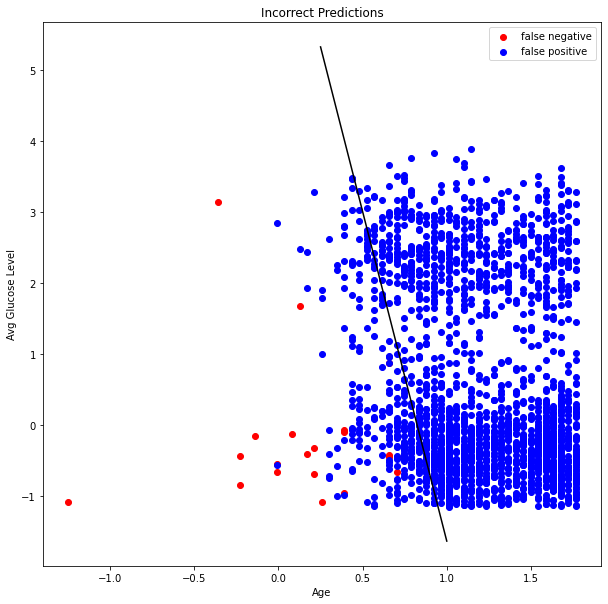

In [94]:
# Test function
wrong_pred_visualized(log_reg, X_test, y_test, list(X.columns))

We see much more false positives than we see false negatives. This is due to the class weighting that we implemeted during training. This regression was trained to treat incorrect predictions of stroke vs non-stroke very differently since we have a very imbalanced dataset.

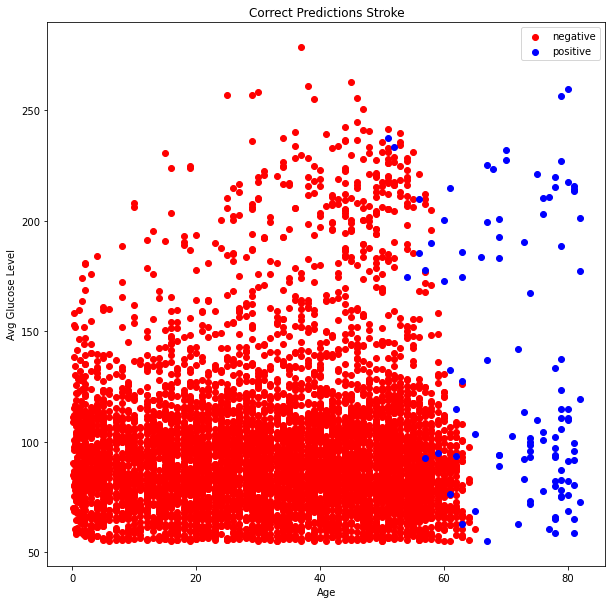

In [101]:
def correct_pred_visualized(scikit_reg, x_test_data, y_test_data, cols, scaler):

    # Plotting the correctly labeled data
    pred = scikit_reg.predict(x_test_data)
    true_pred_x = scaler.inverse_transform(x_test_data[pred == y_test_data])
    true_pred = pred[pred == y_test_data]
    true_neg = pd.DataFrame(true_pred_x[true_pred == 0], columns=cols)
    true_pos = pd.DataFrame(true_pred_x[true_pred == 1], columns=cols)

    # Plotting age on the x axis and glucose on the y axis
    plt.figure(figsize=(10,10))
    plt.scatter(true_neg["age"], true_neg["avg_glucose_level"], label="negative", color="r")
    plt.scatter(true_pos["age"], true_pos["avg_glucose_level"], label="positive", color="b")
    plt.xlabel("Age")
    plt.ylabel("Avg Glucose Level")
    plt.title("Correct Predictions Stroke")
    plt.legend()
    plt.show()
    

correct_pred_visualized(log_reg, X_test, y_test, list(X.columns), scaler)

### Precision/Recall Curve

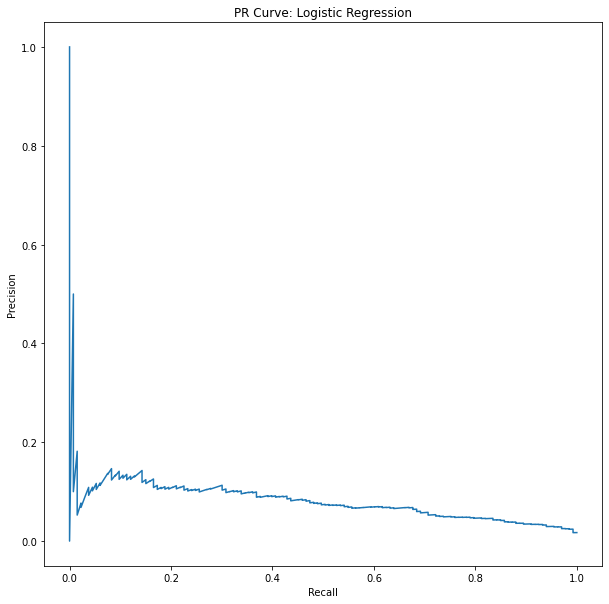

In [147]:
from sklearn import metrics
log_score = X_test @ log_reg.coef_[0, :]
precision, recall, threshold = metrics.precision_recall_curve(y_test, log_score)

plt.figure(figsize=(10,10))
plt.plot(recall, precision)
plt.title("PR Curve: Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

For this model we see a very poor precision for recall values greater than 0.1. This can be seen from the graph above and the graph of incorrectly labled test data. In the incorrectly labeled test data, we see that there is a large number of incorrectly labeled strokes and only a few incorrectly labeled non-strokes. This is likely due to the imbalance in the label dataset that we attempted to correct for using class weights. These class weights trained the logisitic regression to place a smaller penalty on incorrectly labeling strokes vs a larger penalty on incorrectly labeling a non-stroke. 

## Logistic Regression with Balanced Data
Using the unbalanced dataset with unequal class weights resulted in very poor precision. Here we will attempt two different methods: 1) Down sampling the dataset so that we have an equal number of non-stroke and stroke patients 2) Up sampling the stroke paitients (repetition) so that we again have an equal number of non-stroke and stroke paitients. 

In [82]:
from sklearn.utils import shuffle
# Down sampling the data frame so we have the same number of stroke and non-stroke
healthy_paitients = final_df.loc[final_df["stroke"] == 0]
stroke_paitients = final_df.loc[final_df["stroke"] == 1]

num_stroke_paitients = stroke_paitients.shape[0]

down_sample_df = shuffle(pd.concat([healthy_paitients.sample(n=num_stroke_paitients), stroke_paitients]))

X_ds = down_sample_df.drop(["stroke"], axis=1)
y_ds = down_sample_df["stroke"]

# Split and Scale data
X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(X_ds, y_ds, test_size=0.2, random_state=0)
ds_scaler = StandardScaler()
X_train_ds = ds_scaler.fit_transform(X_train_ds)
X_test_ds = ds_scaler.transform(X_test_ds)

### Fitting Logistic Regression on Downsampled Data

In [83]:
log_reg_ds = LogisticRegression(penalty="l2", max_iter=2000, solver="saga", class_weight="balanced")
log_reg_ds.fit(X_train_ds, y_train_ds)
log_pred_ds = log_reg_ds.predict(X_test_ds)
print(f"Number of patients in test dataset: {log_pred_ds.size}")
print(f"Predicted stroke victims in test dataset: {np.sum(log_pred_ds):.2f}")
print(f"Correct number of stroke victims: {np.sum(y_test_ds)}")
print(f"Accuracy of logistic Regression: {1 - np.sum(np.abs(log_pred_ds - y_test_ds))/y_test_ds.size:.3f}")

Number of patients in test dataset: 314
Predicted stroke victims in test dataset: 172.00
Correct number of stroke victims: 159
Accuracy of logistic Regression: 0.774


### Visualizing Predicitons

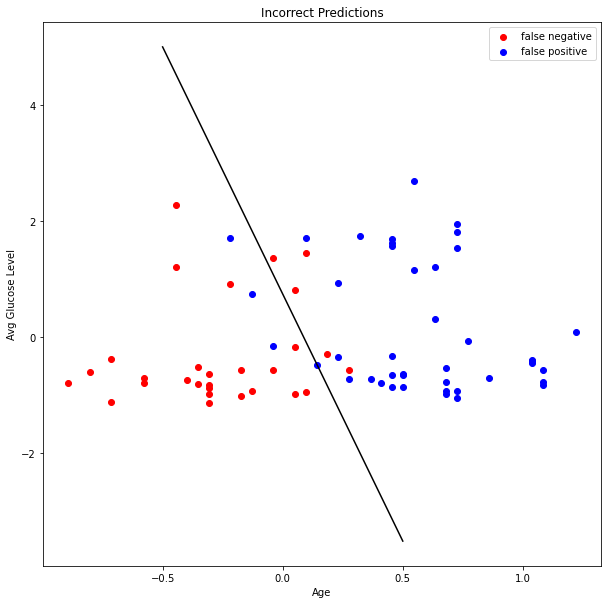

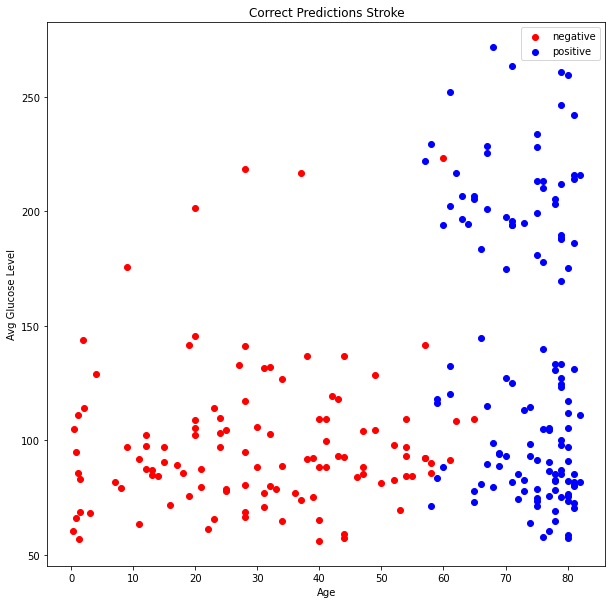

In [102]:
log_reg_ds.intercept_
wrong_pred_visualized(log_reg_ds, X_test_ds, y_test_ds, list(X.columns), T=np.linspace(-0.5, 0.5, 100))
correct_pred_visualized(log_reg_ds, X_test_ds, y_test_ds, list(X.columns), ds_scaler)

### Precision and Recall Plot


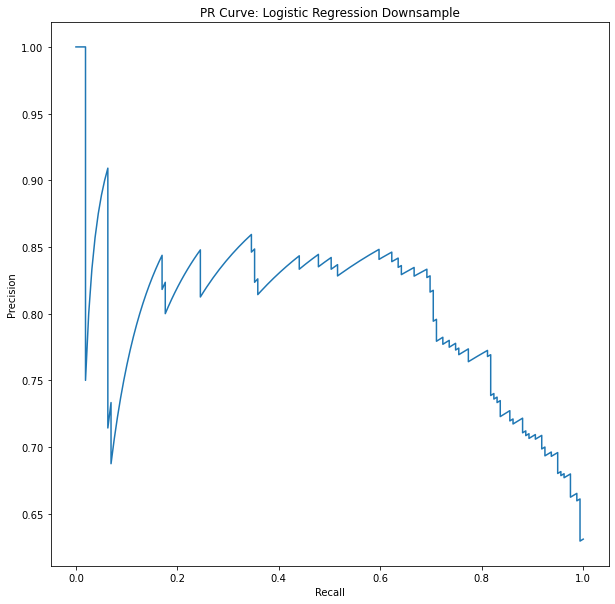

In [145]:
from sklearn import metrics
log_score_ds = X_test_ds @ log_reg_ds.coef_[0, :]
precision_ds, recall_ds, threshold = metrics.precision_recall_curve(y_test_ds, log_score_ds)

plt.figure(figsize=(10,10))
plt.plot(recall_ds, precision_ds)
plt.title("PR Curve: Logistic Regression Downsample")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Upsampled Data

In [137]:
# One of the tricky parts of upsampling data is that we need to repeat data points from the 
# under-represented class (stroke paitients), but we don't want to find any instances of 
# a paitient that finds itself in the training and test dataset. For this reason we will split
# the stroke paitients and non-stroke paititents prior to upsampling so that we create two separate
# sets where there is no overlap of stroke paitients in both training and test sets

# We will use the healthy paitients and stroke paitients from the above example
train_healthy = healthy_paitients.sample(frac=0.8)
test_healthy = healthy_paitients.drop(train_healthy.index)

train_stroke = stroke_paitients.sample(frac=0.8)
test_stroke = stroke_paitients.drop(train_stroke.index)

# Now we upsample our train stroke paitients
healthy_train_num = train_healthy.shape[0]
stroke_train_num = train_stroke.shape[0]
train_ratio = np.ceil(healthy_train_num/stroke_train_num)
train_stroke_us = pd.DataFrame(np.repeat(train_stroke.values, train_ratio, axis=0), columns=train_stroke.columns)

# Upsample our test stroke paitients
healthy_test_num = test_healthy.shape[0]
stroke_test_num = test_stroke.shape[0]
test_ratio = np.ceil(healthy_test_num/stroke_test_num)
test_stroke_us = pd.DataFrame(np.repeat(test_stroke.values, test_ratio, axis=0), columns=test_stroke.columns)

# Select the same number of stroke train paitients as healthy train paitients and concatentate dataframes
# to create a training dataset
subset_train_stroke = train_stroke_us.sample(n=healthy_train_num)
train_data = shuffle(pd.concat([train_healthy, subset_train_stroke]))

# Concatenate test data
subset_test_stroke = test_stroke_us.sample(n=healthy_test_num)
test_data = shuffle(pd.concat([test_healthy, subset_test_stroke]))

# Extract x and y data from train and test
X_train_us = train_data.drop(["stroke"], axis=1)
y_train_us = train_data["stroke"]
X_test_us = test_data.drop(["stroke"], axis=1)
y_test_us = test_data["stroke"]

# Scale data
us_scaler = StandardScaler()
X_train_us = us_scaler.fit_transform(X_train_us)
X_test_us = us_scaler.transform(X_test_us)

### Logistic Regression Upsampled Data

In [138]:
log_reg_us = LogisticRegression(penalty="l2", max_iter=2000, solver="saga")
log_reg_us.fit(X_train_us, y_train_us)
log_pred_us = log_reg_us.predict(X_test_us)
print(f"Number of patients in test dataset: {log_pred_us.size}")
print(f"Predicted stroke victims in test dataset: {np.sum(log_pred_us):.2f}")
print(f"Correct number of stroke victims: {np.sum(y_test_us)}")
print(f"Accuracy of logistic Regression: {1 - np.sum(np.abs(log_pred_us - y_test_us))/y_test_us.size:.3f}")

Number of patients in test dataset: 17046
Predicted stroke victims in test dataset: 8906.00
Correct number of stroke victims: 8523.0
Accuracy of logistic Regression: 0.761


### Visualize Incorrect/Correct Predictions

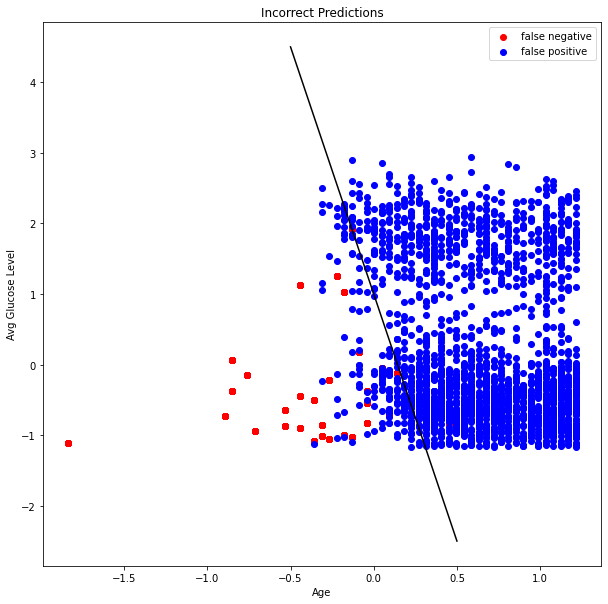

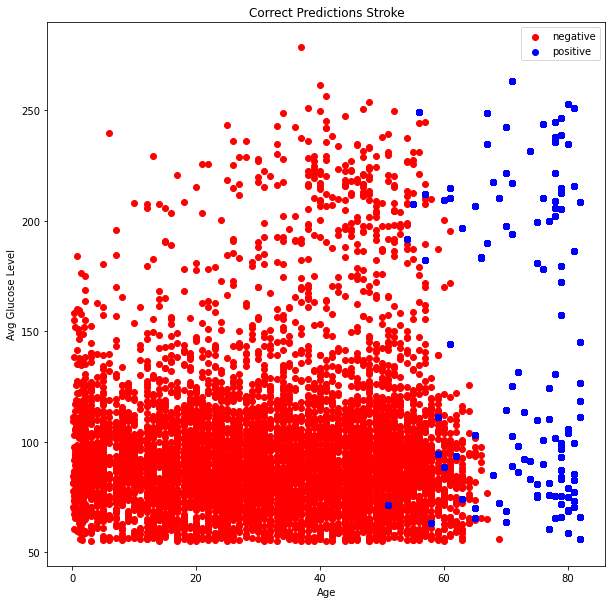

In [140]:
wrong_pred_visualized(log_reg_us, X_test_us, y_test_us, list(X.columns), T=np.linspace(-0.5, 0.5, 100))
correct_pred_visualized(log_reg_us, X_test_us, y_test_us, list(X.columns), us_scaler)

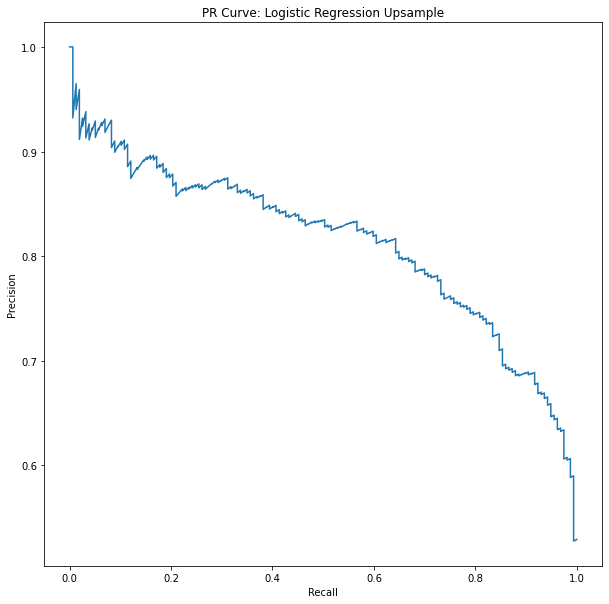

In [143]:
# Recall curve
log_score_us = X_test_us @ log_reg_us.coef_[0, :]
precision_us, recall_us, threshold = metrics.precision_recall_curve(y_test_us, log_score_us)

plt.figure(figsize=(10,10))
plt.plot(recall_us, precision_us)
plt.title("PR Curve: Logistic Regression Upsample")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Compare PR for all Data Balancing Tactics

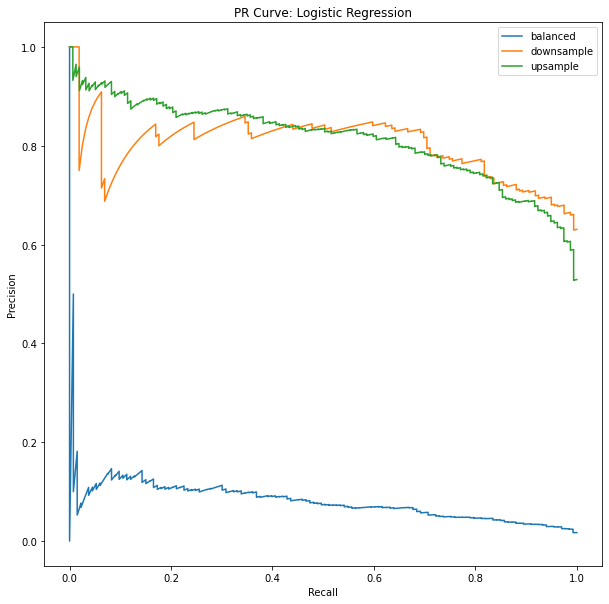

In [148]:
plt.figure(figsize=(10,10))
plt.plot(recall, precision, label="balanced")
plt.plot(recall_ds, precision_ds, label="downsample")
plt.plot(recall_us, precision_us, label="upsample")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve: Logistic Regression")
plt.legend()
plt.show()

## Lasso Fit With KFold

In [36]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.linear_model import LassoCV
kf = KFold(n_splits=5)
kf_train = kf.get_n_splits(X_train)
lasso = LassoCV(cv=kf_train, max_iter=2000, random_state=2)
lasso.fit(X_train, y_train)
lasso.get_params()

{'alphas': None,
 'copy_X': True,
 'cv': 5,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 2000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': False,
 'positive': False,
 'precompute': 'auto',
 'random_state': 2,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

In [37]:
print(f"Lasso lambda is : {lasso.alpha_:.2E}")
print("Lasso coefficients: \n", lasso.coef_)

Lasso lambda is : 4.04E-04
Lasso coefficients: 
 [ 0.00000000e+00  2.53913795e-02  3.09574320e-03  8.68538257e-03
 -5.37051955e-03  6.63503931e-05  5.00848371e-03 -2.47438760e-03
 -1.04874680e-03  7.70747561e-05 -0.00000000e+00  0.00000000e+00
  6.72497605e-03 -0.00000000e+00  0.00000000e+00 -2.28277216e-04
  0.00000000e+00]


In [38]:
# Print out unused columns
print("Columns not in active set:", np.array(list(X.columns))[lasso.coef_ == 0])

Columns not in active set: ['gender' 'work_type_Private' 'work_type_Self-employed'
 'smoking_status_Unknown' 'smoking_status_formerly smoked'
 'smoking_status_smokes']


### Change the number of KFold splits
This dataset is too large to apply leave one out cross validation in a reasonable amount of time

In [39]:
kf_100 = KFold(n_splits=100)
kf_train_100 = kf_100.get_n_splits(X_train)
lasso_kf = LassoCV(cv=kf_train_100, max_iter=2000, random_state=2)
lasso_kf.fit(X_train, y_train)

LassoCV(cv=100, max_iter=2000, random_state=2)

In [40]:
print(f"KFold 100 Lasso lambda is : {lasso_kf.alpha_:.2E}")
print("KFold 100 Lasso coefficients: \n", lasso_kf.coef_)

KFold 100 Lasso lambda is : 3.76E-04
KFold 100 Lasso coefficients: 
 [ 0.00000000e+00  2.54993484e-02  3.11373133e-03  8.69494989e-03
 -5.43909532e-03  9.37039258e-05  5.02821093e-03 -2.50257233e-03
 -1.06889524e-03  1.07547194e-04 -0.00000000e+00  0.00000000e+00
  6.78001993e-03 -0.00000000e+00  0.00000000e+00 -2.47630422e-04
  0.00000000e+00]


In [41]:
# Print out unused columns
print("Columns not in active set:", np.array(list(X.columns))[lasso_kf.coef_ == 0])

Columns not in active set: ['gender' 'work_type_Private' 'work_type_Self-employed'
 'smoking_status_Unknown' 'smoking_status_formerly smoked'
 'smoking_status_smokes']


## Compare Lasso Resuls with LinearRegression

In [42]:
from sklearn.linear_model import LinearRegression
# Perform linear regression prediction
reg = LinearRegression()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

# Predict from both lasso
pred_lasso_10 = lasso.predict(X_test)
pred_lasso_100 = lasso_kf.predict(X_test)

# Compare MSE
mses = []
mses.append(((pred - y_test)**2).mean())
mses.append(((pred_lasso_10 - y_test)**2).mean())
mses.append(((pred_lasso_100 - y_test)**2).mean())
print(f"Linear Regression MSE: {mses[0]:.2E}")
print(f"Lasso KFold 10 MSE: {mses[1]:.2E}")
print(f"Lasso KFold 100 MSE: {mses[1]:.2E}")

Linear Regression MSE: 1.46E-02
Lasso KFold 10 MSE: 1.46E-02
Lasso KFold 100 MSE: 1.46E-02


### Checking Accuracy of Each Predictor

In [43]:
acc = (y_test.size - np.sum(np.abs(np.round(pred) - y_test)))/y_test.size
acc_kf_10 = (y_test.size - np.sum(np.abs(np.round(pred_lasso_10) - y_test)))/y_test.size
acc_kf_100 = (y_test.size - np.sum(np.abs(np.round(pred_lasso_100) - y_test)))/y_test.size
print(f"Linear Regression accuracy {acc*100:.2f} %")
print(f"Lasso KFold 10 accuracy {acc_kf_10*100:.2f} %")
print(f"Lasso KFold 100 accuracy {acc_kf_100*100:.2f} %")

Linear Regression accuracy 98.47 %
Lasso KFold 10 accuracy 98.47 %
Lasso KFold 100 accuracy 98.47 %


After fitting the lasso on this data set, it seems like residence type and gender don't have much of an effect on stroke prediction. I notice that a lot of the smoking status variables are also being thrown out, but I still see the never smokes variable in the active set. This suggests that there may be little significance between formerly smoking and currently smoking in terms of stroke prediction. These findings are supported by the results of the MSE and Accuracy testing between linear regression and both lasso regressions. The linear regression is training with all of the input variables, but the lasso regression is training without gender, residence type, and several other data categories. The accuracy and mse of the lasso predictions exactly match the linear predictions, suggesting that omitting these data categories has negligible impact on the ability to predict a stroke. 

In [44]:
np.sum(np.round(pred_lasso_10))

0.0

In [45]:
np.sum(y_test)

133